In [2]:
import pandas as pd 
import numpy as np 
import pyro
import torch
from torch.distributions import constraints
import pyro.distributions as dist
from pyro.infer.autoguide import AutoDelta
import pyro.poutine as poutine
from pyro.infer import TraceEnum_ELBO, SVI, config_enumerate, infer_discrete
from collections import defaultdict
import matplotlib.pyplot as plt
from matplotlib import pyplot
import scipy.stats

In [3]:
# Model declaration for GMM Cluster
K=2
# @config_enumerate
def model(data, K=2, d=2):
    pi = pyro.sample('pi', dist.Dirichlet(0.5 * torch.ones(K)))
    with pyro.plate('component', K) as idx:
        mu = pyro.sample('mu', dist.MultivariateNormal(torch.ones(d), (10)*torch.eye(d)))
        sigma = pyro.sample('sigma', dist.InverseGamma(1,1))
    with pyro.plate('data', len(data)):
        assignment = pyro.sample('assignment', dist.Categorical(pi))
        sigma_ = sigma[assignment].repeat(d, d, 1).transpose(2, 0)
        sigma_ *= torch.eye(d).repeat(len(assignment), 1, 1)
        pyro.sample('obs', dist.MultivariateNormal(mu[assignment], sigma_), obs = data)
guide = AutoDelta(poutine.block(model, expose=['pi','mu','sigma']))

# Running the GMM model with SVI for this iteration.

In [4]:
# note that both covariance matrices are diagonal
num_samples = 1000
mu1 = torch.tensor([0., 5.])
sig1 = torch.tensor([[2., 0.], [0., 2.]])

mu2 = torch.tensor([5., 0.])
sig2 = torch.tensor([[2., 0.], [0., 2.]])

# generate samples
dist1 = dist.MultivariateNormal(mu1, sig1)
samples1 = [pyro.sample('samples1', dist1) for _ in range(num_samples)]

dist2 = dist.MultivariateNormal(mu2, sig2)
samples2 = [pyro.sample('samples2', dist2) for _ in range(num_samples)]


In [5]:
dummy_data = torch.cat((torch.stack(samples1), torch.stack(samples2)))


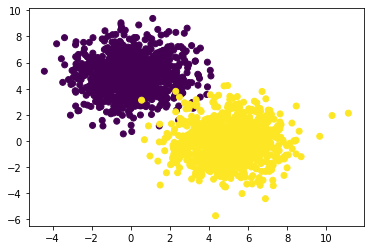

In [6]:
plt.scatter(dummy_data[:,0], dummy_data[:,1], c = [0 for i in range(num_samples)] + [1 for i in range(num_samples)])


# Inference using SVI 

In [7]:
optim = pyro.optim.Adam({'lr':0.01})
elbo = TraceEnum_ELBO()
svi = SVI(model, guide, optim, loss=elbo)


In [35]:
def initialize(seed):
    pyro.set_rng_seed(seed)
    pyro.clear_param_store()
#     # Initialize weights to uniform.
    pyro.param('auto_pi', 0.5 * torch.ones(K), constraint=constraints.simplex)
#     # Assume half of the data variance is due to intra-component noise.
    pyro.param('auto_sigma', torch.stack([(dummy_data[:,0].var() / 2).sqrt(), (dummy_data[:,1].var() / 2).sqrt()]), constraint=constraints.positive)
#     # Initialize means from a subsample of data.
    pyro.param('auto_mu', torch.tensor([[0., 5.],[5.0,0]]))
    loss = svi.loss(model, guide, dummy_data)
    return loss

loss, seed = min((initialize(seed), seed) for seed in range(1000))
initialize(seed)
print('seed = {}, initial_loss = {}'.format(seed, loss))

seed = 87, initial_loss = 19830.33984375


In [36]:
dummy_data[torch.multinomial(torch.ones(len(dummy_data)) / len(dummy_data), 2)]

tensor([[-1.0264,  4.4241],
        [ 4.8367, -0.5910]])

## Adding parameter, losses to monitor.

In [37]:
gradiant_norms = defaultdict(list)
for name, value in pyro.get_param_store().named_parameters():
    value.register_hook(lambda g, name=name:gradiant_norms[name].append(g.norm().item()))
    
losses = []
for i in range(200):
    loss = svi.step(dummy_data)
    losses.append(loss)

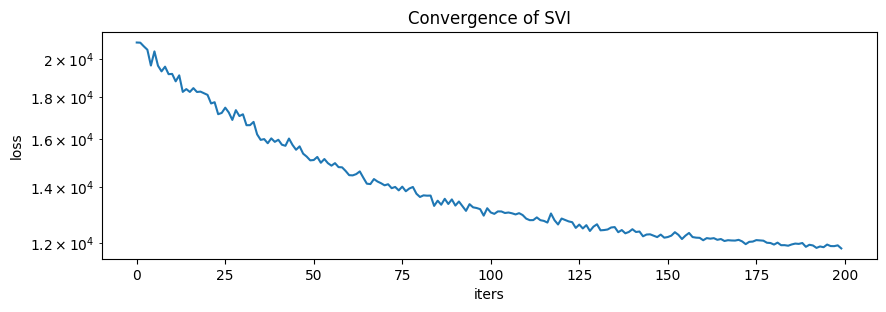

In [38]:
pyplot.figure(figsize=(10,3), dpi=100).set_facecolor('white')
pyplot.plot(losses)
pyplot.xlabel('iters')
pyplot.ylabel('loss')
pyplot.yscale('log')
pyplot.title('Convergence of SVI');


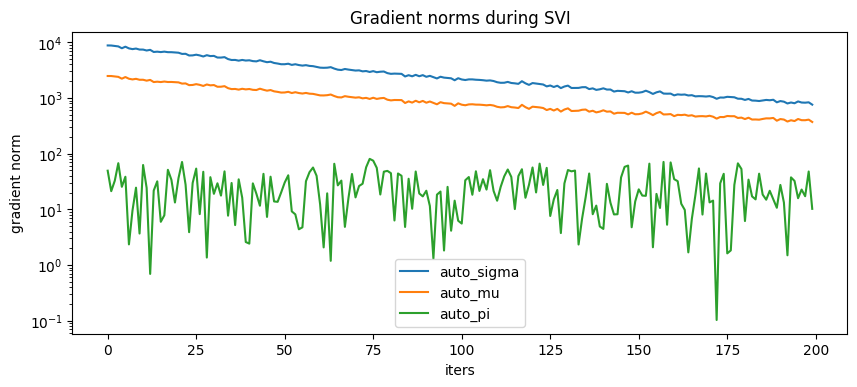

In [39]:
pyplot.figure(figsize=(10,4), dpi=100).set_facecolor('white')
for name, grad_norms in gradiant_norms.items():
    pyplot.plot(grad_norms, label=name)
pyplot.xlabel('iters')
pyplot.ylabel('gradient norm')
pyplot.yscale('log')
pyplot.legend(loc='best')
pyplot.title('Gradient norms during SVI');


In [40]:
from pyro.contrib.autoguide import AutoDiagonalNormal
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO, TraceEnum_ELBO
from pyro.infer import EmpiricalMarginal, SVI, Trace_ELBO, TracePredictive


In [41]:
posterior = svi.run(dummy_data)

sites = ["mu", "sigma", "pi"]

svi_samples = {
    site: EmpiricalMarginal(
        posterior, sites=site
    ).enumerate_support().detach().cpu().numpy()
    for site in sites
}

means = np.mean(svi_samples["mu"], 0)
pi = np.mean(svi_samples['pi'],0)
sigma = np.mean(svi_samples['sigma'], 0 )

In [42]:
means, pi, sigma

(array([[1.2131559, 3.7804208],
        [3.6918716, 1.3071872]], dtype=float32),
 array([0.451716, 0.548284], dtype=float32),
 array([6.02142  , 6.5322046], dtype=float32))

In [43]:
map_estimates = guide(dummy_data)
pi = map_estimates['pi']
mu = map_estimates['mu']
sigma = map_estimates['sigma']
print('pi = {}'.format(pi.data.numpy()))
print('mu = {}'.format(mu.data.numpy()))
print('sigma = {}'.format(sigma.data.numpy()))


pi = [0.45171604 0.548284  ]
mu = [[1.213156  3.7804205]
 [3.6918716 1.3071872]]
sigma = [6.02142   6.5322046]


# Infering Mixture Assignments

In [44]:
guide_trace = poutine.trace(guide).get_trace(dummy_data)  # record the globals
trained_model = poutine.replay(model, trace=guide_trace)  # replay the globals

def classifier(data):
    inferred_model = infer_discrete(trained_model,
                                    first_available_dim=-2)  # avoid conflict with data plate
    trace = poutine.trace(inferred_model).get_trace(data)
    return trace.nodes["assignment"]["value"]

ass = classifier(dummy_data)


In [45]:
colo = ['red' if x==0 else 'blue' for x in ass.tolist()]  + ['green', 'pink']

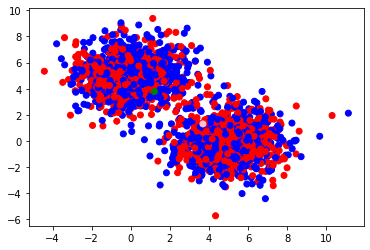

In [46]:
plt.scatter(x = dummy_data[:,0].tolist()+[float(mu[0][0]), float(mu[1][0])],
            y = dummy_data[:,1].tolist()+[float(mu[0][1]), float(mu[1][1])],
            c = colo)